# Annotating Cellines

This workbook is supposed to be run after the standard workflow.
It demonstrates  how to use the  signature (**sig**) module and its annotation functions to assign cell type to the cluster of the dataset that was runned through the standard worflow.

In this notebook, we will show how to use in-besca annotation to assign cell type to clusters.

We focus on immune celltype and demonstrate signature-scoring functions.


When it is possible to have a training dataset already annotated, one can use the auto-annot module.

Please refer to the corresponding tutorial.

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy.api as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
import pkg_resources
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning
/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
## this was creatied by the standard_workflow notebook.
#define standardized filepaths based on above input
root_path = os.getcwd()
analysis_name = 'standard_workflow_besca2.0'
results_folder = os.path.join(root_path, 'analyzed', analysis_name)


In [3]:

adata = sc.read_h5ad(os.path.join(results_folder, analysis_name + '.h5ad') )
adata


AnnData object with n_obs × n_vars = 9842 × 1341 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch', 'percent_mito', 'n_counts', 'n_genes', 'leiden'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

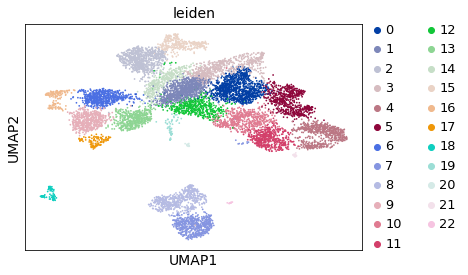

In [4]:
sc.pl.umap(adata, color= ['leiden'])

In [5]:
# ONe can load besca-provided signatures using the function below
signature_dict = bc.datasets.load_immune_signatures(refined=False)

signature_dict

{'Bcell': ['CD19', 'CD79A', 'MS4A1'],
 'CD4': ['CD4'],
 'CD8': ['CD8ACD8B'],
 'NKcell': ['NKG7', 'GNLY', 'NCAM1'],
 'Tcells': ['CD3ECD3G', 'CD3D'],
 'lymphocyte': ['PTPRC'],
 'macrophage': ['CD14',
  'IL1B',
  'LYZ    CD163   ITGAX',
  'CD68',
  'CSF1R',
  'FCGR3A'],
 'monocyte': ['CST3', 'CSF1R', 'ITGAM', 'CD14', 'FCGR3A', 'FCGR3B'],
 'myeloid': ['S100A8', 'S100A9', 'CST3']}

Additionaly it is possible to read an compute scanpy score using this function below.

If the gmt file is composed of combined signature (UP and DN), a common score will be computed: 
$$Total\_SCORE= Score_{UP} - Score_{DN}$$

In [6]:
gmt_file_IMM= pkg_resources.resource_filename('besca', 'datasets/genesets/Immune.gmt')
bc.tl.sig.combined_signature_score(adata, gmt_file_IMM,
                             UP_suffix='_UP', DN_suffix='_DN', method='scanpy',
                             overwrite=False, verbose=False,
                             use_raw=True, conversion=None)

/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/scanpy/tools/_score_genes.py:115: RuntimeWarning:

Mean of empty slice



In [7]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]

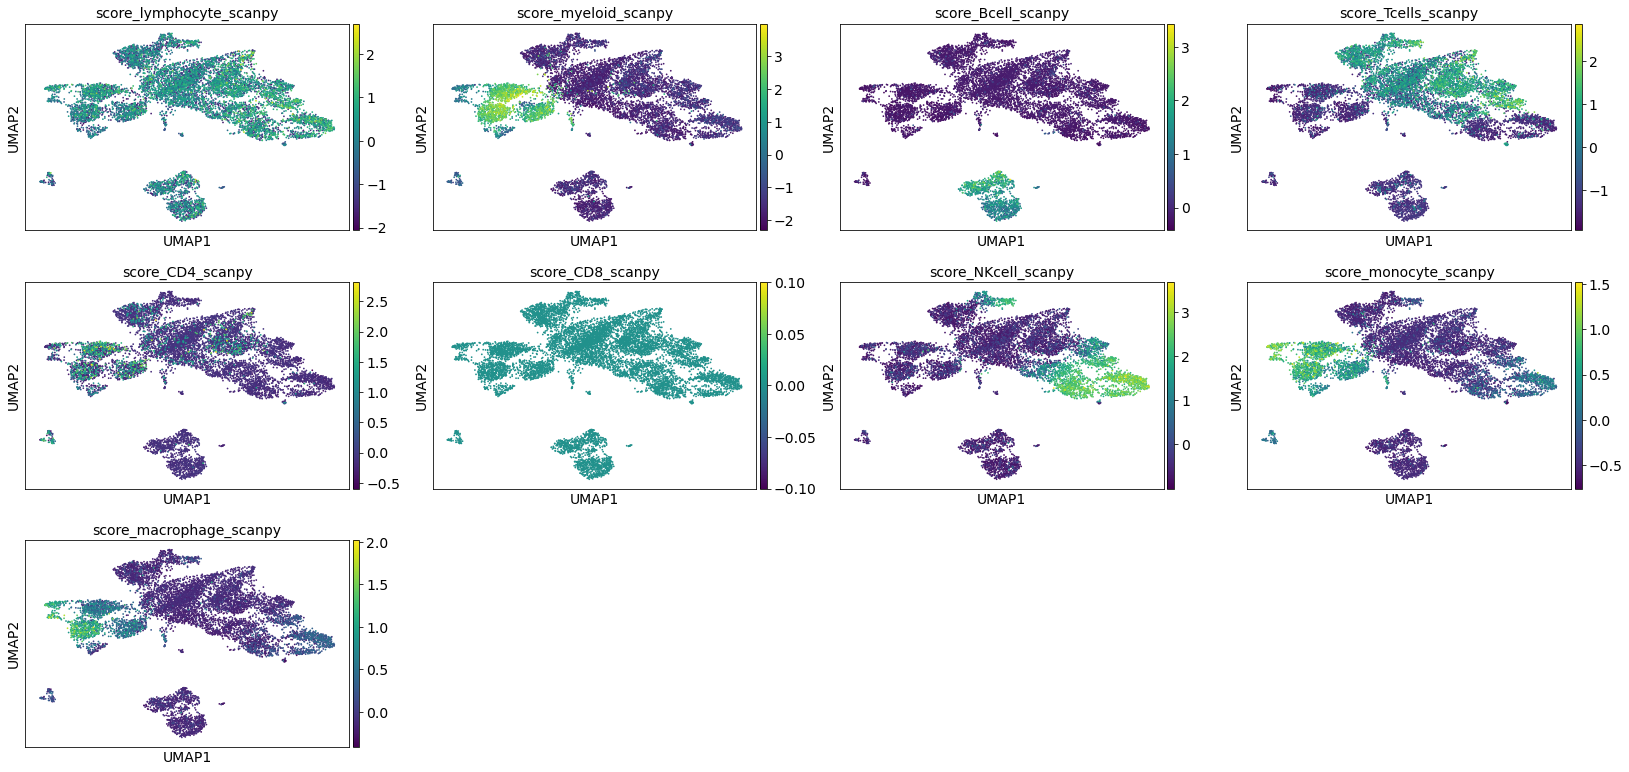

In [8]:
sc.pl.umap(adata, color= scores)

# Immune signatures for specific sub-populations

In [9]:
 ## PROVIDED WITH BESCA
gmt_file_IMM= pkg_resources.resource_filename('besca', 'datasets/genesets/HumanCD45p_scseqCMs6.gmt')
bc.tl.sig.combined_signature_score(adata, gmt_file_IMM)


/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/scanpy/tools/_score_genes.py:115: RuntimeWarning:

Mean of empty slice



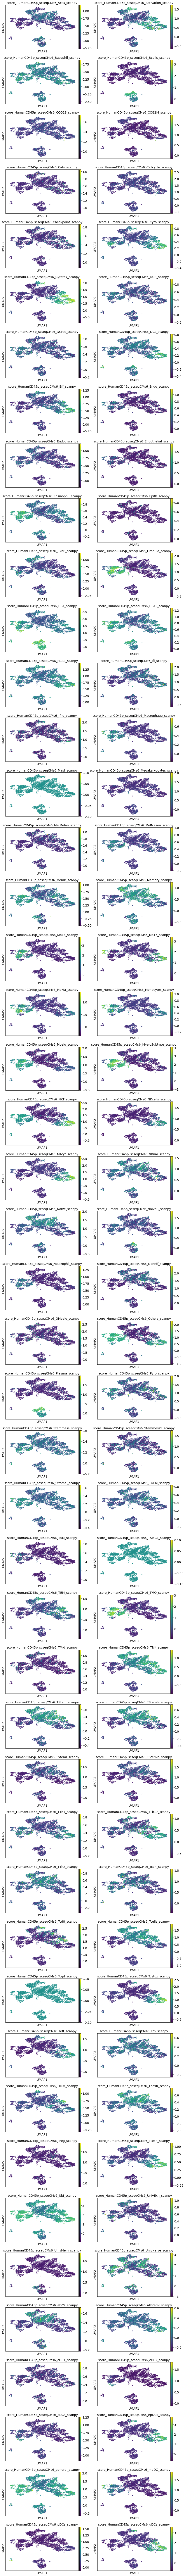

In [10]:
scores = [x for x in adata.obs.columns if 'CD45' in x]
sc.pl.umap(adata, color= scores, color_map = 'viridis', ncols=2)

# Automated annotation

We encompass some automatated decision-tree annotation for PBMCs, TILCs and the immuno-compartment within single cell data.

This is an aid to start population annotations and such annotation can then be further refined. It was tested mainly on PBMCs and oncology (ie. tumor) related samples.


In [11]:
mymarkers  = bc.datasets.load_immune_signatures()
mymarkers.keys()

dict_keys(['HumanCD45p_scseqCMs6_ActB', 'HumanCD45p_scseqCMs6_Activation', 'HumanCD45p_scseqCMs6_Basophil', 'HumanCD45p_scseqCMs6_Bcells', 'HumanCD45p_scseqCMs6_CCG1S', 'HumanCD45p_scseqCMs6_CCG2M', 'HumanCD45p_scseqCMs6_Cafs', 'HumanCD45p_scseqCMs6_Cellcycle', 'HumanCD45p_scseqCMs6_Checkpoint', 'HumanCD45p_scseqCMs6_Cyto', 'HumanCD45p_scseqCMs6_Cytotox', 'HumanCD45p_scseqCMs6_DCR', 'HumanCD45p_scseqCMs6_DCrec', 'HumanCD45p_scseqCMs6_DCs', 'HumanCD45p_scseqCMs6_Eff', 'HumanCD45p_scseqCMs6_Endo', 'HumanCD45p_scseqCMs6_Endot', 'HumanCD45p_scseqCMs6_Endothelial', 'HumanCD45p_scseqCMs6_Eosinophil', 'HumanCD45p_scseqCMs6_Epith', 'HumanCD45p_scseqCMs6_ExhB', 'HumanCD45p_scseqCMs6_Granulo', 'HumanCD45p_scseqCMs6_HLA', 'HumanCD45p_scseqCMs6_HLAP', 'HumanCD45p_scseqCMs6_HLAS', 'HumanCD45p_scseqCMs6_Ifi', 'HumanCD45p_scseqCMs6_Ifng', 'HumanCD45p_scseqCMs6_Macrophage', 'HumanCD45p_scseqCMs6_Mast', 'HumanCD45p_scseqCMs6_Megakaryocytes', 'HumanCD45p_scseqCMs6_MelMelan', 'HumanCD45p_scseqCMs6_MelMes

Immune annotation provided by Besca are starting by a prefix indicating the version of the current annotation (genesets).

Here we can see that the prefix is:

**HumanCD45p_scseqCMs6**

An initial threshold has to be set. A possibility is to use the ubiquitous signature as below.
Myc will be the 'standard' threshold that will help generate sub-population multiple thresholds.

In [12]:
setName = 'HumanCD45p_scseqCMs6'
# Fract_pos was exported by BESCA in the standard worflow test
f=pd.read_csv(results_folder + "/labelings/leiden/fract_pos.gct",sep="\t",skiprows=2)
df=bc.tl.sig.score_mw(f,mymarkers)


myc=np.median(df.loc[setName+'_Ubi',:]*2/3)


/pstore/home/julienla/miniconda3/envs/besca_2/lib/python3.6/site-packages/scipy/stats/stats.py:6415: RuntimeWarning:

divide by zero encountered in double_scalars



The different sub cell-populations will be assigned in 
**make_anno**

This function uses a csv file to see up the thresholds for the different population.
Here to allow more personalized thresholding, **Besca** offers to write an initial thresholding file that can then be modified *a-posteriori* based on the specificities of each datasets.


Cut-off and sub-population assignation will then be based:
- df: generated using -10(log10(pvalue)) of a mann-whitney tests based on the gene exression percentage (% of cells in a cluster expressing genes within a geneset).

In [13]:
# Setting up the threshold files
bc.tl.sig.generate_annot_threshold( myc = myc, filename = 'InitialThreshold.csv')# Multiple files can be generated and modified 

thresholdDict = bc.tl.sig.get_threshold('InitialThreshold.csv')
thresholdDict

{'Activation': {'0': 43.073474502469715},
 'Bcells': {'0': 43.073474502469715},
 'Cafs': {'0': 43.073474502469715},
 'Cellcycle': {'0': 57.43129933662628},
 'Checkpoint': {'0': 43.073474502469715},
 'Cytotox': {'0': 86.14694900493943},
 'Eff': {'0': 43.073474502469715},
 'Endo': {'0': 43.073474502469715},
 'Granulo': {'0': 43.073474502469715},
 'Ifng': {'0': 43.073474502469715},
 'Macrophage': {'0': 43.073474502469715},
 'Megakaryocytes': {'0': 43.073474502469715},
 'MelMelan': {'0': 43.073474502469715},
 'Memory': {'0': 43.073474502469715},
 'Mo14': {'0': 43.073474502469715},
 'Mo16': {'0': 43.073474502469715},
 'Monocytes': {'0': 43.073474502469715},
 'Myelo': {'0': 43.073474502469715},
 'MyeloSubtype': {'0': 43.073474502469715},
 'NKT': {'0': 64.61021175370456},
 'NKcells': {'0': 86.14694900493943},
 'NKcyt': {'0': 86.14694900493943},
 'NKnai': {'0': 43.073474502469715},
 'Naive': {'0': 43.073474502469715},
 'Neutrophil': {'0': 43.073474502469715},
 'Plasma': {'0': 43.07347450246971

In [14]:

cNames=bc.tl.sig.make_anno(df,setName,f,thresholdDict, CD45threshold=0.3,)
print(cNames)
adata=bc.tl.sig.add_anno(adata,cNames, 'leiden')

['C0.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C1.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C2.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C3.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C4.CD45.NK.Cyt..nNa.nCC.nCy.nCh.nAc', 'C5.CD45.Tc.8.texh.nNa.nCC.Cy.nCh.nAc', 'C6.CD45.My.TMO..nNa.nCC.nCy.nCh.nAc', 'C7.CD45.Bc.Bc..nNa.nCC.nCy.nCh.nAc', 'C8.CD45.Bc.Bc..nNa.nCC.nCy.nCh.nAc', 'C9.CD45.My.TMO..nNa.nCC.nCy.nCh.nAc', 'C10.CD45.Tc.4.Cytox.nNa.nCC.Cy.nCh.nAc', 'C11.CD45....nNa.nCC.nCy.nCh.nAc', 'C12.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C13.CD45.My.TMO..nNa.nCC.nCy.nCh.nAc', 'C14.CD45.Tc.4.Nai.Na.nCC.nCy.nCh.nAc', 'C15.CD45.Tc.8.EM.Na.nCC.Cy.nCh.nAc', 'C16.CD45.My.moDC..nNa.nCC.nCy.nCh.nAc', 'C17.CD45....nNa.nCC.nCy.nCh.nAc', 'C18.CD45.My.pDC..nNa.nCC.nCy.nCh.nAc', 'C19.CD45.My.TMO..nNa.nCC.nCy.nCh.nAc', 'C20.CD45....nNa.nCC.nCy.nCh.nAc', 'C21.CD45.Tc.4.CC.nNa.CC.nCy.nCh.nAc', 'C22.CD45.Bc.Pl..nNa.nCC.nCy.nCh.nAc']


Function add_anno will have separated cNames to multiple sub columns in the observations of the annData object for the observation of the clusters assignation at different granularity 

... storing 'cell_names' as categorical
... storing 'cell_group' as categorical
... storing 'scell_group' as categorical
... storing 'sscell_group' as categorical


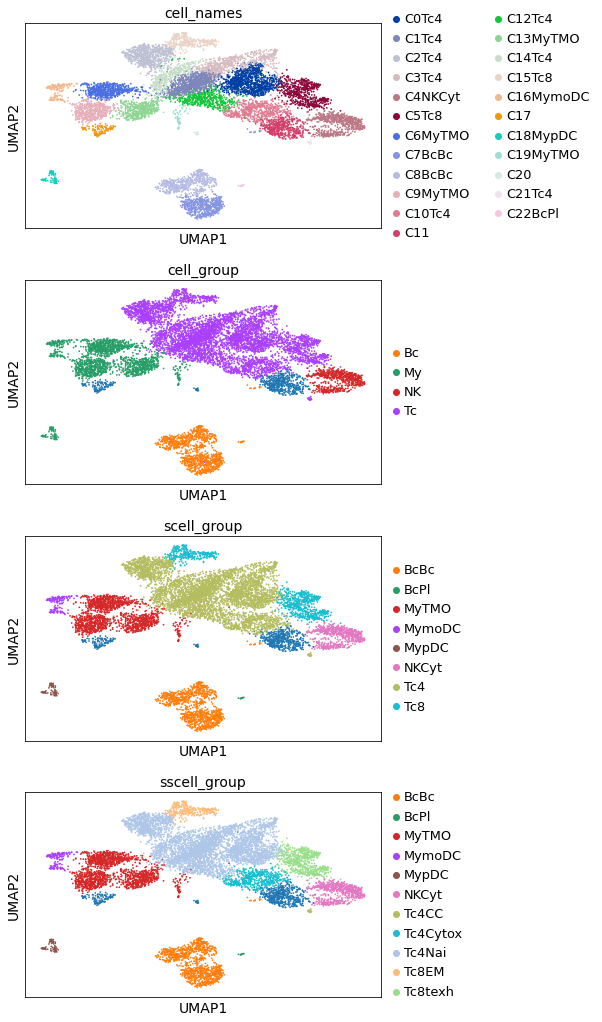

In [15]:
sc.pl.umap(adata, color= ['cell_names', 'cell_group', 'scell_group', 'sscell_group'], ncols = 1)